In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
from warnings import simplefilter,filterwarnings
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore',category = FutureWarning)
simplefilter(action='ignore',category = RuntimeWarning)
filterwarnings(action='ignore',category=DataConversionWarning)

In [4]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517


In [10]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]
print("X shape:",X.shape)
print("y shape:",y.shape)
print("Min y:",min(np.array(y))[0])
print("Max y:",max(np.array(y))[0])

X shape: (264, 1135)
y shape: (264, 1)
Min y: 0.0117532464005208
Max y: 4.9270454514617015


## Visualize our data

We would like to visualize how the values of the output are distributed, using a histogram. 

Since our output values range from 0.01 to 4.92, it makes sense to display our output in bins from [0-1] to [4-5]

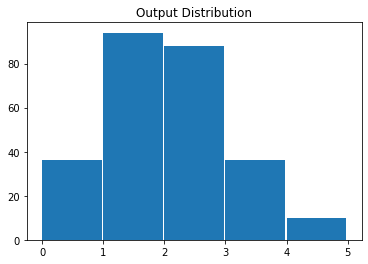

In [13]:
hist, bin_edges = np.histogram(y, bins = 5, range = (0,5))
fig = plt.figure()
plt.bar(bin_edges[:-1],hist,width=.98,align='edge')
plt.title("Output Distribution")
plt.show()